In [189]:
import json

# Charger les données des fichiers JSON
with open('données_normales.json', 'r') as f:
    donnees_normales = json.load(f)

with open('html_injection.json', 'r') as f:
    html_injection = json.load(f)

# Ajouter la colonne attack_type
for donnee in donnees_normales:
    donnee['attack_type'] = "No attacks"

for donnee in html_injection:
    donnee['attack_type'] = "HTML injection"

# Fusionner les deux listes de données
donnees_fusionnees = donnees_normales + html_injection

# Afficher un exemple de données fusionnées
print(donnees_fusionnees[:2])

[{'method': 'GET', 'url': '/htmli_get.php', 'query_parameters': {'firstname': '<h1>Alice</h1>', 'lastname': '<div>Dupont</div>', 'address': "<script>alert('XSS')</script>", 'email': '<img src="x" onerror="alert(\'XSS\')">', 'form': 'submit'}, 'headers': {'Host': '127.0.0.1:8000', 'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8', 'Accept-Language': 'en-US,en;q=0.5', 'Accept-Encoding': 'gzip, deflate, br', 'Connection': 'keep-alive', 'Referer': "http://127.0.0.1:8000/htmli_get.php?firstname=%3Ch1%3EAlice%3C%2Fh1%3E&lastname=%3Cdiv%3EDupont%3C%2Fdiv%3E&address=%3Cscript%3Ealert('XSS')%3C%2Fscript%3E&email=%3Cimg%20src%3D%22x%22%20onerror%3D%22alert('XSS')%22%3E&form=submit", 'Cookie': 'security_level=0; PHPSESSID=5oat10nbn3rene9rfj94lc52i7', 'Upgrade-Insecure-Requests': '1', 'Sec-Fetch-Dest': 'document', 'Sec-Fetch-Mode': 'navigate', 'Sec-Fetch-Site': 's

In [138]:
# Sauvegarder les données fusionnées dans un fichier JSON
with open('donnees_fusionnees.json', 'w') as f:
    json.dump(donnees_fusionnees, f)

In [139]:
#import json

# Charger les données existantes
with open('donnees_fusionnees.json', 'r') as f:
    existing_data = json.load(f)

# Charger les nouvelles données générées
with open('synthetic_data.json', 'r') as f:
    new_data = json.load(f)

# Combiner les deux ensembles de données
combined_data = existing_data + new_data

# Sauvegarder les données combinées
with open('donnees_fusionnees.json', 'w') as f:
    json.dump(combined_data, f, indent=4)

In [140]:
import json
import csv

# Charger le fichier JSON
with open('donnees_fusionnees.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Ouvrir un fichier CSV en mode écriture
with open('donnees_fusionnees.csv', 'w', encoding='utf-8', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Si le JSON est une liste d'objets
    if isinstance(data, list):
        # Convertir les dictionnaires dans query_parameters et headers en chaînes JSON
        for item in data:
            if isinstance(item.get('query_parameters'), dict):
                item['query_parameters'] = json.dumps(item['query_parameters'])
            if isinstance(item.get('headers'), dict):
                item['headers'] = json.dumps(item['headers'])
        
        # Écrire les en-têtes (clés du premier élément)
        writer.writerow(data[0].keys())
        
        # Écrire les valeurs de chaque objet JSON
        for item in data:
            writer.writerow(item.values())
    else:
        print("Le fichier JSON n'est pas dans le bon format pour une conversion en CSV.")


In [15]:
import json
import pandas as pd
from urllib.parse import urlparse, parse_qs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump
from imblearn.over_sampling import SMOTE

# Lire les données depuis un fichier JSON
df = pd.read_json('donnees_fusionnees.json')

# Fonction pour détecter les mots-clés SQL
def detect_sql_keywords(query):
    sql_keywords = ["SELECT", "INSERT", "UPDATE", "DELETE", "DROP", "UNION", "ALTER", "CREATE", "EXEC", "XP_", " OR "]
    return any(keyword in query.upper() for keyword in sql_keywords)

# Fonction pour détecter les mots-clés HTML
def detect_html_keywords(query):
    html_keywords = ["<script>", "<img>", "<div>", "<h1>", "<b>", "<i>", "<span>"]
    return any(keyword in query.lower() for keyword in html_keywords)

# Extraire les valeurs des query_parameters
def extract_values(query_parameters):
    if isinstance(query_parameters, dict):
        return ' '.join(query_parameters.values())
    return ''

# Ajouter une colonne pour détecter les mots-clés SQL
df['sql_keywords_detected'] = df['query_parameters'].apply(
    lambda x: detect_sql_keywords(extract_values(x))
)

# Ajouter une colonne pour détecter les mots-clés HTML
df['html_keywords_detected'] = df['query_parameters'].apply(
    lambda x: detect_html_keywords(extract_values(x))
)

# Convertir les valeurs des query_parameters en une chaîne de caractères
df['query_parameters_values'] = df['query_parameters'].apply(lambda x: extract_values(x))

# Filtrer les données pour exclure les "HTML injection"
df = df[df['attack_type'] != 'HTML injection']

# Supprimer les colonnes inutiles et encoder les variables catégorielles
X = df[['url','query_parameters_values', 'body', 'sql_keywords_detected', 'html_keywords_detected']]

# Convertir les colonnes booléennes en entiers
X.loc[:, 'sql_keywords_detected'] = X['sql_keywords_detected'].astype(int)
X.loc[:, 'html_keywords_detected'] = X['html_keywords_detected'].astype(int)

# Encoder les variables catégorielles
X = pd.get_dummies(X, columns=['url','query_parameters_values', 'body'], dummy_na=True)

# Sauvegarder les colonnes utilisées dans un fichier JSON
with open('columns.json', 'w') as f:
    json.dump(list(X.columns), f)

y = df['attack_type']

# Vérifier l'équilibre des classes
print(y.value_counts())

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Utiliser SMOTE pour suréchantillonner les classes minoritaires
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier l'équilibre des classes après suréchantillonnage
print(y_train_resampled.value_counts())

# Entraîner le modèle avec validation croisée
model = RandomForestClassifier()
scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

# Entraîner le modèle sur l'ensemble d'entraînement complet
model.fit(X_train_resampled, y_train_resampled)

# Évaluer le modèle sur l'ensemble de test
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

C:\Users\paulj\AppData\Local\Temp\ipykernel_42612\3335416266.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0

attack_type
No attack        395
SQL injection    200
XSS               53
Name: count, dtype: int64
attack_type
SQL injection    314
No attack        314
XSS              314
Name: count, dtype: int64
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
               precision    recall  f1-score   support

    No attack       1.00      1.00      1.00        81
SQL injection       1.00      1.00      1.00        39
          XSS       1.00      1.00      1.00        10

     accuracy                           1.00       130
    macro avg       1.00      1.00      1.00       130
 weighted avg       1.00      1.00      1.00       130

[[81  0  0]
 [ 0 39  0]
 [ 0  0 10]]


In [16]:
# Sauvegarder le modèle
dump(model, 'forensic.pkl')

['forensic.pkl']

In [192]:
print(df.columns)


Index(['method', 'url', 'query_parameters', 'headers', 'attack_type',
       'sql_keywords_detected', 'html_keywords_detected'],
      dtype='object')


In [9]:
print(df['attack_type'].value_counts())


attack_type
No attack        298
SQL injection    200
XSS               53
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Validation croisée - Accuracy :", scores.mean())


Validation croisée - Accuracy : 1.0


In [11]:
feature_importances = model.feature_importances_
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance}")


sql_keywords_detected: 0.3139703379765706
html_keywords_detected: 0.3121335268146009
url_/DVWA/vulnerabilities/sqli/: 0.031631939942646896
url_/DVWA/vulnerabilities/sqli/?id=1%27%20OR%20%271%27%3D%271%27%23&Submit=Submit: 0.00016299886656394972
url_/DVWA/vulnerabilities/sqli/?id=1&Submit=Submit: 0.0
url_/DVWA/vulnerabilities/sqli/?id=10%27%20OR%20%275%27%3D%275%27%23&Submit=Submit: 0.0
url_/DVWA/vulnerabilities/sqli/?id=10&Submit=Submit: 0.0
url_/DVWA/vulnerabilities/sqli/?id=100%27%20OR%20%2787%27%3D%2787%27%23&Submit=Submit: 0.00019989540855127157
url_/DVWA/vulnerabilities/sqli/?id=100&Submit=Submit: 0.000666816165961135
url_/DVWA/vulnerabilities/sqli/?id=11%27%20OR%20%276%27%3D%276%27%23&Submit=Submit: 0.00029342390338492157
url_/DVWA/vulnerabilities/sqli/?id=11&Submit=Submit: 0.0
url_/DVWA/vulnerabilities/sqli/?id=12%27%20OR%20%277%27%3D%277%27%23&Submit=Submit: 0.00014412141711980838
url_/DVWA/vulnerabilities/sqli/?id=12&Submit=Submit: 0.0
url_/DVWA/vulnerabilities/sqli/?id=13%27%

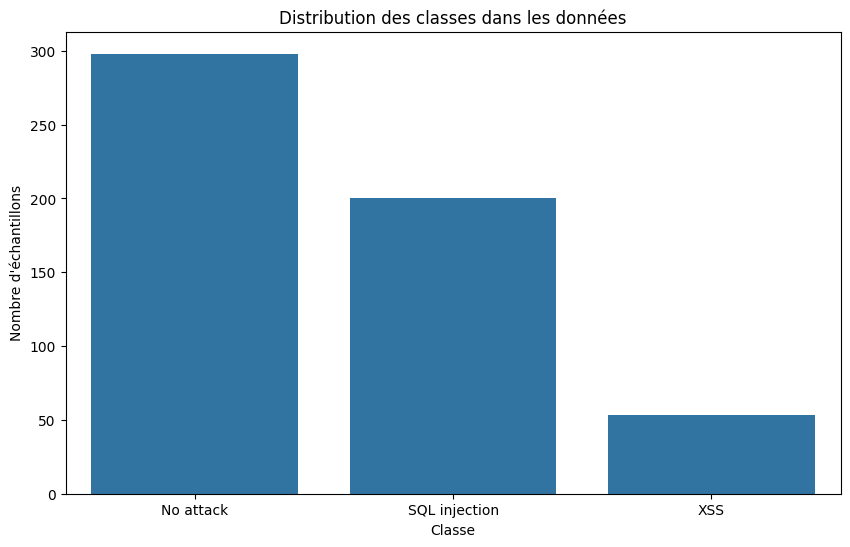

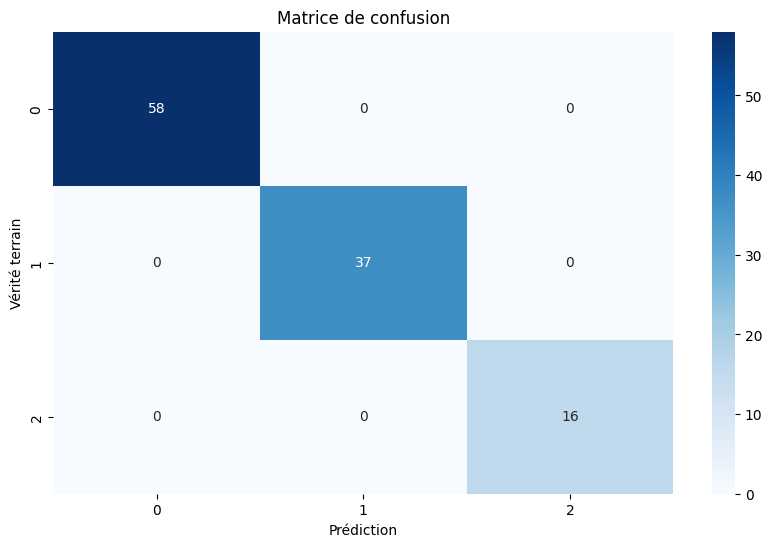

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Distribution des classes dans les données
plt.figure(figsize=(10, 6))
sns.countplot(x='attack_type', data=df)
plt.title('Distribution des classes dans les données')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()
y_pred = model.predict(X_test[:len(y_test)])  # Pour s'assurer que les tailles sont égales

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# Importance des caractéristiques
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

In [13]:
import pandas as pd

# Supposons que 'model' soit votre modèle entraîné et 'X_train' soit votre ensemble de données d'entraînement
feature_importances = model.feature_importances_
features = X_train.columns

# Créer un DataFrame pour les importances des caractéristiques
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher le tableau d'importance des caractéristiques
importance_df

,Feature,Importance
0,sql_keywords_detected,0.313970
1,html_keywords_detected,0.312134
341,query_parameters_values_,0.086874
695,body_,0.045934
2,url_/DVWA/vulnerabilities/sqli/,0.031632
...,...,...
845,body_id=77&Submit=Submit,0.000000
762,body_id=39&Submit=Submit,0.000000
765,body_id=4+or+1%3D1+union+select+user%2Cpasswor...,0.000000
894,body_nan,0.000000


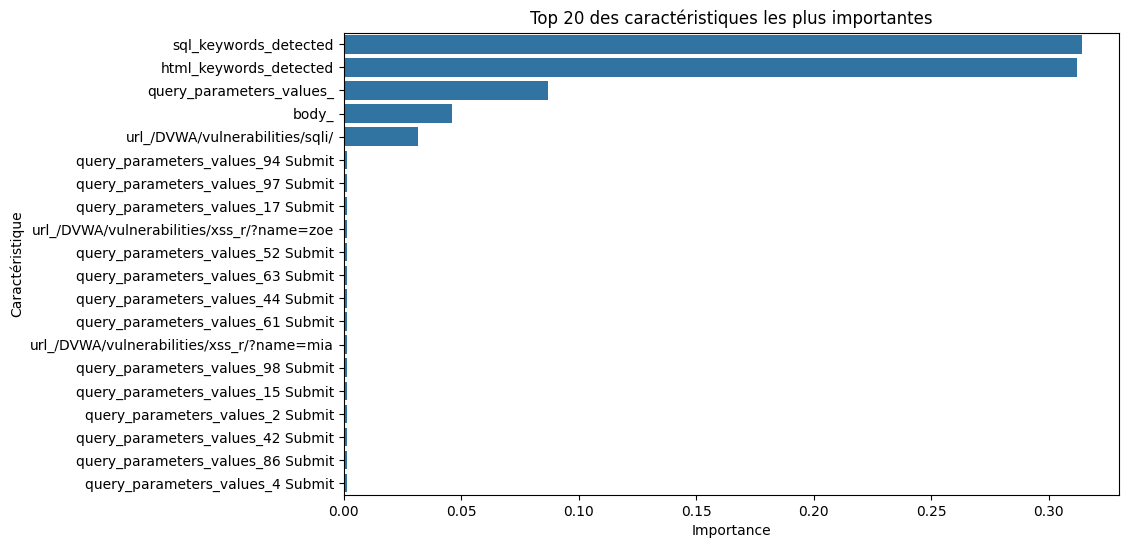

In [14]:
# Sélectionner les 20 caractéristiques les plus importantes
top_20_importance_df = importance_df.head(20)

# Afficher le tableau d'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df)
plt.title('Top 20 des caractéristiques les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.show()

In [237]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(model, 'forensic.pkl')

['forensic.pkl']

In [203]:
# Prédire les valeurs pour l'ensemble de test
y_pred_all = model.predict(X_test)

# Afficher les prédictions
for true_value, predicted_value in zip(y_test, y_pred_all):
    print(f"Vérité terrain: {true_value}, Prédiction: {predicted_value}")
    # Prédire les valeurs pour l'ensemble complet
    y_pred_all = model.predict(X)

    # Afficher toutes les prédictions
    for true_value, predicted_value in zip(y, y_pred_all):
        print(f"Vérité terrain: {true_value}, Prédiction: {predicted_value}")

Vérité terrain: SQL injection, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, Prédiction: No attacks
Vérité terrain: No attacks, 